In [1]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits

import matplotlib

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
rootdir = Path("/Volumes/LaCie 8TB/wfsdat")
# use find to make this csv list
with open(rootdir / "reanalyze_csvs_2020_q2.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [3]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
f5,135,1,f5,135


In [4]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
fixed = fixed[fixed['time'] > "2019-12-30"]

In [5]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,focerr,cc_x_err,cc_y_err,xcen,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms
0,2020-06-19T23:16:20,f5,manual_wfs_0000.fits,30.0,1.0118,-50.139787,81.255085,15.25,15.1,14.704,...,-37.30,0.000,5.187,242.004657,274.994119,0.732095,0.737267,5.030702,997.715816,1097.256268
1,2020-06-19T23:16:20,f5,manual_wfs_0001.fits,30.0,1.0124,-51.227273,81.007485,15.25,15.1,14.714,...,-0.43,0.000,-1.181,247.978429,266.018027,0.643675,0.648452,4.609532,284.220949,1129.837928
2,2020-06-19T23:16:21,f5,manual_wfs_0002.fits,25.0,1.0132,-52.260739,80.753522,15.00,15.1,14.704,...,-5.66,0.000,-3.162,249.018879,270.019880,0.634702,0.639715,4.568075,292.656896,1137.032539
3,2020-06-19T23:16:21,f5,manual_wfs_0003.fits,30.0,1.1240,-67.431988,62.835498,14.00,14.2,14.073,...,-12.36,2.085,-4.410,242.003150,265.989120,0.943265,1.011797,6.320966,435.048181,1236.911231
10,2020-06-19T23:16:22,f5,manual_wfs_0010.fits,30.0,1.2231,-74.824510,54.846152,11.75,12.5,12.698,...,7.50,0.000,-4.171,237.990634,247.994369,0.823840,0.929651,5.937362,318.281651,1562.759632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2020-06-29T20:58:58,f5,manual_wfs_0005.fits,30.0,1.1007,-6.160229,65.295984,11.50,11.9,12.108,...,4.87,-0.000,-0.000,220.004021,259.001083,2.626677,2.782327,14.038004,634.427483,1747.535509
0,2020-07-04T23:03:43,f5,manual_wfs_0000.fits,30.0,1.1981,311.810739,56.579878,14.00,14.2,14.173,...,24.86,-13.986,4.731,252.022067,261.996847,1.533649,1.709313,9.478506,803.190116,1110.508652
2,2020-07-04T23:03:44,f5,manual_wfs_0002.fits,30.0,1.1767,313.460898,58.192669,11.50,11.6,12.192,...,-55.63,-1.211,-1.370,237.016140,242.012655,1.403518,1.547453,8.761350,1422.165756,1509.782217
1,2020-07-04T23:03:44,f5,manual_wfs_0001.fits,30.0,1.2003,311.729189,56.420072,14.00,14.2,14.173,...,-1.07,-0.647,-0.692,249.990730,259.984268,1.555239,1.735286,9.592769,282.576384,1097.628000


In [6]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

<Figure size 576x360 with 0 Axes>

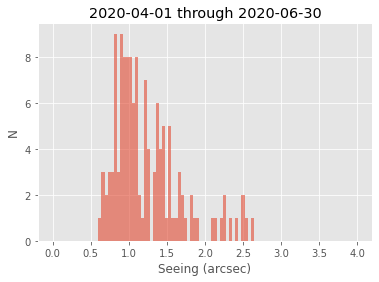

In [7]:
# make raw histogram of the zenith-corrected seeing column
fig = plt.figure(figsize=(8, 5))
fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
plt.title("2020-04-01 through 2020-06-30")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
plt.show()

In [8]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(fixed['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['seeing'])
fit_median = exp_mu + loc

0.5796205606760458 0.48460283604183585 0.6378967077348838


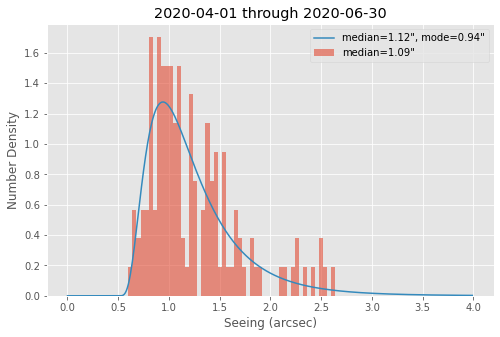

In [9]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
plt.hist(fixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
logp = plt.plot(x, p, label="logp")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("Number Density")
plt.title("2020-04-01 through 2020-06-30")
plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
    median
)])
plt.savefig("2020q2_hist.png")
plt.show()

In [11]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months['January'] = fixed['2020-01']
months['February'] = fixed['2020-02']
months['March'] = fixed['2020-03']
for m in months:
    plt.hist(months[m]['seeing'], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]['seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2020q1_monthly.png")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
len(months['January']), len(months['February']), len(months['March'])

(10630, 398, 2661)

In [13]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

In [14]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2020q1_1st2nd.png")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.seeing.resample('D').median()
daily['max'] = fixed.seeing.resample('D').max()
daily['min'] = fixed.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
fig.autofmt_xdate()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2020q1_nightly.pdf")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(fixed[date]['seeing']) for date in date_list]
clean_data = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

In [18]:
fig, ax = plt.subplots(figsize=(11,5))
plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
               showextrema=False, showmedians=True, bw_method='silverman')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
fig.autofmt_xdate()
plt.ylabel("Seeing (arcsec)")
plt.savefig("2020q1_violin.pdf")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
bino = fixed[fixed['wfs'] == "binospec"]

In [20]:
bino['dir'] = bino.index.strftime("/Volumes/LaCie 8TB/wfsdat/%Y%m%d")

/Users/tim/conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
xcen = []
ycen = []
starx = []
stary = []
filenames = []
for i, row in bino.iterrows():
    p = os.path.join(row['dir'], row['file'])
    hdul = fits.open(p)
    hdr = hdul[1].header
    xcen.append(row['xcen'])
    ycen.append(row['ycen'])
    starx.append(hdr['STARXMM'])
    stary.append(hdr['STARYMM'])
    filenames.append(p)
    hdul.close()

In [27]:
xcen = np.array(xcen)
ycen = np.array(ycen)
starx = np.array(starx)
stary = np.array(stary)

In [42]:
fig = plt.figure(figsize=(8, 5))
plt.scatter(stary, ycen)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [40]:
miny, maxy = np.argmin(stary), np.argmax(stary)
minx, maxx = np.argmin(starx), np.argmax(starx)

In [30]:
filenames[miny], filenames[maxy]

('/Volumes/LaCie 8TB/wfsdat/20200127/wfs_ff_cal_img_2020.0127.041552.fits',
 '/Volumes/LaCie 8TB/wfsdat/20200126/wfs_ff_cal_img_2020.0126.061610.fits')

In [34]:
np.where((stary < 5) & (stary > -5))

(array([3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930,
        3931, 3932, 3933, 3934, 3935, 3936, 3937, 8596, 8597, 8598, 8599,
        8600, 8601, 8602, 8603, 8604, 8605, 8606, 8607, 8608, 8609, 8610,
        8611, 8612, 8613, 8614, 8615, 8616, 8617, 8618, 8619, 8620, 8621,
        8622, 8623, 8624, 8625, 8626, 8627, 8628, 8629, 8630, 8631, 8632,
        8633, 8634, 8635, 8636, 8637, 8638, 8639, 8640, 8641, 8642, 8643,
        8644, 8645, 8646, 8647, 8648, 8649, 8650, 8651, 8652, 8653, 8654,
        8655, 8656, 8657, 8658, 8659, 8660, 8661, 8662, 8663, 8664, 8665,
        8666, 8667, 8668, 8669, 8670, 8671, 8672, 8673, 8674, 8675, 8676,
        8677, 8678, 8679, 8680, 8681, 8682, 8683, 8684, 8685, 8686, 8687,
        8688, 8689, 8690, 8691, 8692, 8693, 8694, 8695, 8696, 8697, 8698,
        8699, 8700, 8701, 8702, 8703, 8704, 8705, 8706, 8707, 8708, 8709,
        8710, 8711, 8712, 8713, 8714, 8715, 8716, 8717, 8718, 8719, 8720,
        8721, 8722, 8723, 8724, 8725, 

In [35]:
filenames[8670]

'/Volumes/LaCie 8TB/wfsdat/20200317/wfs_ff_cal_img_2020.0317.043649.fits'

In [41]:
filenames[minx], filenames[maxx]

('/Volumes/LaCie 8TB/wfsdat/20200127/wfs_ff_cal_img_2020.0127.015209.fits',
 '/Volumes/LaCie 8TB/wfsdat/20200124/wfs_ff_cal_img_2020.0124.075451.fits')